**Part 3**

Importing libraries and loading the images

In [40]:
import os
import torch
import torchvision
from torchvision.transforms import transforms
from sklearn.model_selection import StratifiedShuffleSplit
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
data_path = '/kaggle/input/cnn-dataset'

In [6]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
dataset = torchvision.datasets.ImageFolder(
    root=data_path,
    transform=transform
)

In [8]:
# Splitting the dataset into training and testing sets while keeping the class distribution equal
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices, test_indices = next(strat_split.split(dataset, dataset.targets))

In [9]:
train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

Statistics on dataset

In [11]:
num_classes = len(dataset.classes)
print("Number of classes:", num_classes)

Number of classes: 3


In [12]:
classes = dataset.classes
classes

['dogs', 'food', 'vehicles']

In [14]:
images_per_class = []
for i in range(num_classes):
    images_per_class.append(len(dataset.targets) / num_classes)
print("Images per class:", images_per_class)

Images per class: [10000.0, 10000.0, 10000.0]


In [15]:
total_entries = len(dataset)
print("Total number of entries:", total_entries)

Total number of entries: 30000


In [16]:
total_images_per_class = [0] * num_classes
for idx in range(total_entries):
    total_images_per_class[dataset.targets[idx]] += 1

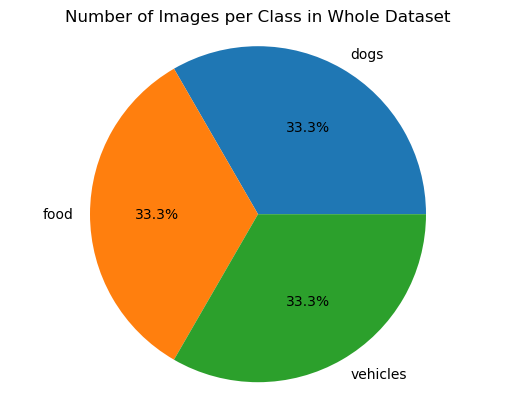

In [18]:
plt.pie(total_images_per_class, labels=classes, autopct='%1.1f%%')
plt.title("Number of Images per Class in Whole Dataset")
plt.axis('equal')
plt.show()

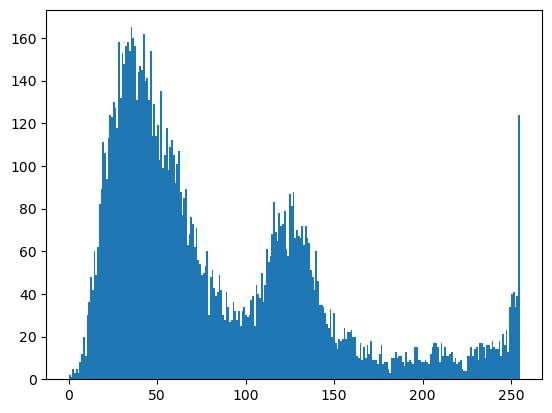

In [21]:
image_path = "/kaggle/input/cnn-dataset/dogs/1.jpg"
img = Image.open(image_path)

# Convert the image to a numpy array
img_arr = np.array(img)

# Plot the histogram of the image
plt.hist(img_arr.ravel(), bins=256, range=(0, 255))
plt.show()

In [23]:
# Get the number of images per class in the training set
train_images_per_class = [0] * num_classes
for idx in train_indices:
    train_images_per_class[dataset.targets[idx]] += 1
print("Images per class in the training set:", train_images_per_class)

Images per class in the training set: [8000, 8000, 8000]


In [24]:
# Get the number of images per class in the testing set
test_images_per_class = [0] * num_classes
for idx in test_indices:
    test_images_per_class[dataset.targets[idx]] += 1
print("Images per class in the testing set:", test_images_per_class)

Images per class in the testing set: [2000, 2000, 2000]


In [25]:
def plot_images(images, labels):
    fig, axes = plt.subplots(nrows=1, ncols=len(images), figsize=(12, 3))
    for i, ax in enumerate(axes):
        ax.imshow(np.transpose(images[i], (1, 2, 0)))
        ax.set_title(classes[labels[i]])
        ax.axis("off")
    plt.show()


In [26]:
train_size=len(train_dataset)
train_size

24000

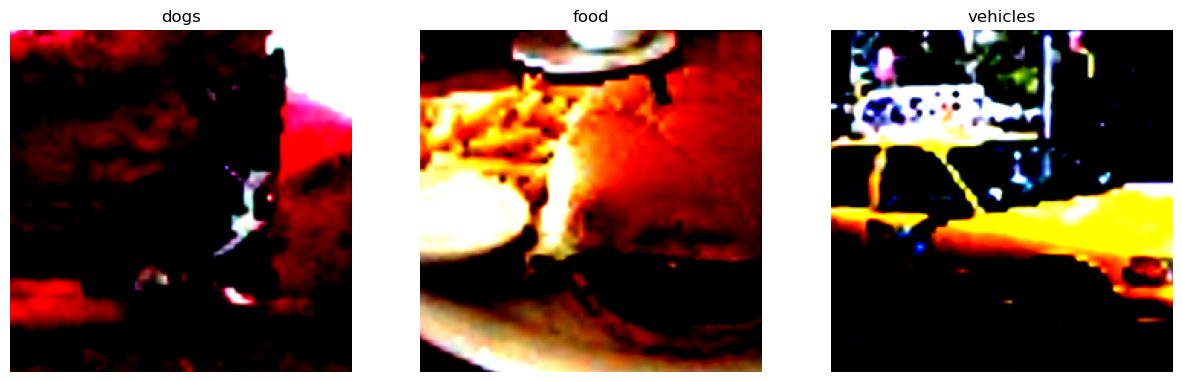

In [34]:
train_images = []
train_labels = []
for i in range(num_classes):
    idx = dataset.targets.index(i)
    train_images.append(dataset[idx][0])
    train_labels.append(dataset.classes[i])

# Plot the training images with labels
fig, ax = plt.subplots(1, num_classes, figsize=(15, 5))
for i in range(num_classes):
    ax[i].imshow(train_images[i].permute(1, 2, 0))
    ax[i].set_title(train_labels[i])
    ax[i].axis('off')
plt.show()

In [23]:
test_size=len(test_dataset)
test_size

6000

In [24]:
# Get random indices for five images from the testing set
test_indices = np.random.choice(test_size, size=5, replace=True)
test_images = [dataset[i + train_size][0] for i in test_indices]
test_labels = [dataset.classes[dataset[i + train_size][1]] for i in test_indices]

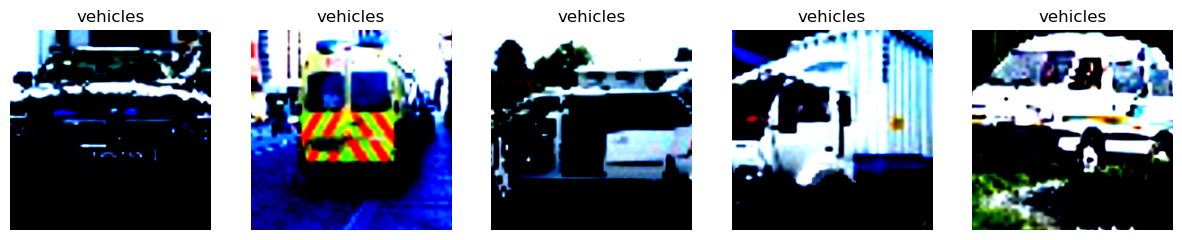

In [25]:
# Plot the testing images with labels
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    ax[i].imshow(test_images[i].permute(1, 2, 0))
    ax[i].set_title(test_labels[i])
    ax[i].axis('off')
plt.show()

In [30]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=3):
        super(AlexNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [31]:
# setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# creatting the model
model = AlexNet().to(device)

# setting the hyperparameters
learning_rate = 0.001
num_epochs = 10

# defining the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate

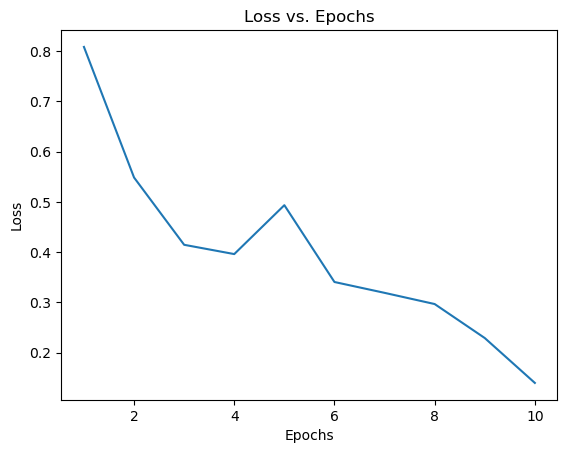

In [42]:
loss_vals = [0.8087, 0.5486, 0.4146, 0.3961, 0.4935, 0.3405, 0.3189, 0.2966, 0.2289, 0.1395]

# Define the x-axis values as epochs
epochs = list(range(1, len(loss_vals)+1))

# Plotting the Loss vs. Epochs graph
plt.plot(epochs, loss_vals)
plt.title("Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

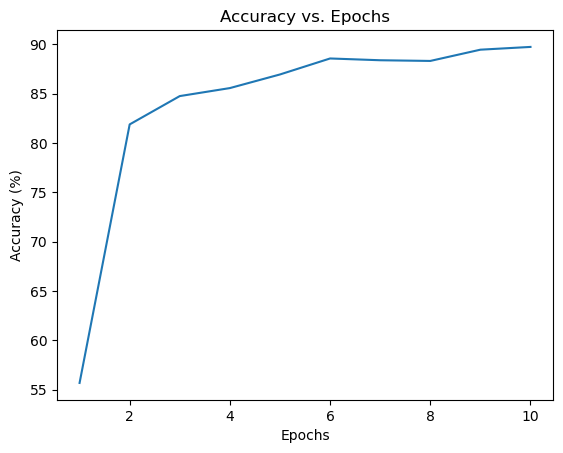

In [43]:
acc_vals = [55.69, 81.88, 84.75, 85.56, 86.94, 88.56, 88.38, 88.31, 89.45, 89.73]

# Define the x-axis values as epochs
epochs = list(range(1, len(acc_vals)+1))

# Plotting the Accuracy vs. Epochs graph
plt.plot(epochs, acc_vals)
plt.title("Accuracy vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.show()

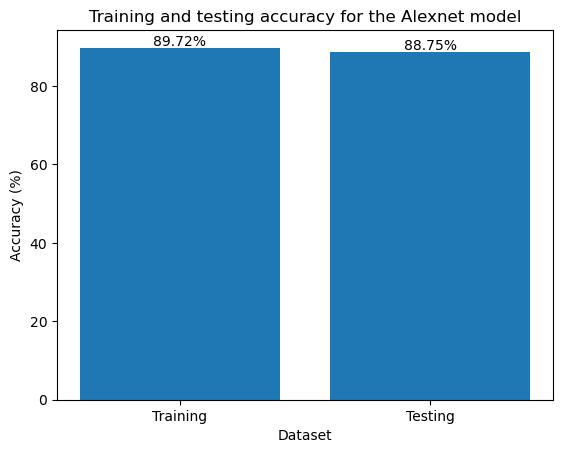

In [49]:
#Accuracy values for training and testing
train_acc, test_acc = 89.72, 88.75
datasets = ('Training', 'Testing')
accuracy_values = [train_acc, test_acc]

fig, ax = plt.subplots()
ax.bar(datasets, accuracy_values)

ax.set_title('Training and testing accuracy for the Alexnet model')
ax.set_xlabel('Dataset')
ax.set_ylabel('Accuracy (%)')
for i, v in enumerate(accuracy_values):
    ax.text(i, v+0.5, f"{v:.2f}%", color='black', ha='center')
plt.show()

In [ ]:
# training the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    train_acc = 0
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_acc += (predicted == labels).sum().item()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item(), 100*train_acc/((i+1)*train_loader.batch_size)))


 13%|█▎        | 100/750 [03:31<22:44,  2.10s/it]

Epoch [1/10], Step [100/750], Loss: 0.8087, Accuracy: 55.69%


 27%|██▋       | 200/750 [07:04<19:25,  2.12s/it]

Epoch [1/10], Step [200/750], Loss: 0.8323, Accuracy: 62.70%


 40%|████      | 300/750 [10:37<15:43,  2.10s/it]

Epoch [1/10], Step [300/750], Loss: 0.6655, Accuracy: 66.12%


 53%|█████▎    | 400/750 [14:09<12:54,  2.21s/it]

Epoch [1/10], Step [400/750], Loss: 0.5272, Accuracy: 69.20%


 67%|██████▋   | 500/750 [17:36<08:29,  2.04s/it]

Epoch [1/10], Step [500/750], Loss: 0.1992, Accuracy: 71.08%


 80%|████████  | 600/750 [21:05<05:20,  2.14s/it]

Epoch [1/10], Step [600/750], Loss: 0.4131, Accuracy: 72.64%


 93%|█████████▎| 700/750 [25:04<02:07,  2.55s/it]

Epoch [1/10], Step [700/750], Loss: 0.4192, Accuracy: 73.83%


 13%|█▎        | 100/750 [04:03<25:03,  2.31s/it]

Epoch [2/10], Step [100/750], Loss: 0.5486, Accuracy: 81.88%


 27%|██▋       | 200/750 [07:57<21:40,  2.36s/it]

Epoch [2/10], Step [200/750], Loss: 0.4832, Accuracy: 81.12%


 40%|████      | 300/750 [11:50<17:18,  2.31s/it]

Epoch [2/10], Step [300/750], Loss: 0.7856, Accuracy: 82.03%


 53%|█████▎    | 400/750 [15:44<13:35,  2.33s/it]

Epoch [2/10], Step [400/750], Loss: 0.2748, Accuracy: 82.12%


 67%|██████▋   | 500/750 [19:36<09:37,  2.31s/it]

Epoch [2/10], Step [500/750], Loss: 0.2556, Accuracy: 82.66%


 80%|████████  | 600/750 [23:28<05:41,  2.27s/it]

Epoch [2/10], Step [600/750], Loss: 0.3268, Accuracy: 82.86%


 93%|█████████▎| 700/750 [27:20<01:54,  2.29s/it]

Epoch [2/10], Step [700/750], Loss: 0.2913, Accuracy: 82.97%


 13%|█▎        | 100/750 [03:53<25:29,  2.35s/it]

Epoch [3/10], Step [100/750], Loss: 0.4146, Accuracy: 84.75%


 27%|██▋       | 200/750 [07:46<21:10,  2.31s/it]

Epoch [3/10], Step [200/750], Loss: 0.3514, Accuracy: 84.80%


 40%|████      | 300/750 [11:35<17:15,  2.30s/it]

Epoch [3/10], Step [300/750], Loss: 0.3122, Accuracy: 84.31%


 53%|█████▎    | 400/750 [15:26<13:17,  2.28s/it]

Epoch [3/10], Step [400/750], Loss: 0.2810, Accuracy: 84.20%


 67%|██████▋   | 500/750 [19:15<09:43,  2.33s/it]

Epoch [3/10], Step [500/750], Loss: 0.2765, Accuracy: 84.30%


 80%|████████  | 600/750 [23:04<05:40,  2.27s/it]

Epoch [3/10], Step [600/750], Loss: 0.5075, Accuracy: 84.41%


 93%|█████████▎| 700/750 [26:53<01:52,  2.26s/it]

Epoch [3/10], Step [700/750], Loss: 0.3216, Accuracy: 84.54%


 13%|█▎        | 100/750 [03:49<24:49,  2.29s/it]

Epoch [4/10], Step [100/750], Loss: 0.3961, Accuracy: 85.56%


 27%|██▋       | 200/750 [07:40<21:03,  2.30s/it]

Epoch [4/10], Step [200/750], Loss: 0.4041, Accuracy: 86.22%


 40%|████      | 300/750 [11:31<17:25,  2.32s/it]

Epoch [4/10], Step [300/750], Loss: 0.2647, Accuracy: 86.18%


 53%|█████▎    | 400/750 [15:20<13:22,  2.29s/it]

Epoch [4/10], Step [400/750], Loss: 0.1864, Accuracy: 86.18%


 67%|██████▋   | 500/750 [19:09<09:26,  2.27s/it]

Epoch [4/10], Step [500/750], Loss: 0.4275, Accuracy: 86.14%


 80%|████████  | 600/750 [22:59<05:59,  2.40s/it]

Epoch [4/10], Step [600/750], Loss: 0.3073, Accuracy: 86.35%


 93%|█████████▎| 700/750 [26:48<01:55,  2.31s/it]

Epoch [4/10], Step [700/750], Loss: 0.2378, Accuracy: 86.32%


 13%|█▎        | 100/750 [03:50<24:58,  2.31s/it]

Epoch [5/10], Step [100/750], Loss: 0.4935, Accuracy: 86.94%


 27%|██▋       | 200/750 [07:40<20:53,  2.28s/it]

Epoch [5/10], Step [200/750], Loss: 0.1981, Accuracy: 86.44%


 40%|████      | 300/750 [11:30<17:02,  2.27s/it]

Epoch [5/10], Step [300/750], Loss: 0.4011, Accuracy: 86.53%


 53%|█████▎    | 400/750 [15:22<14:03,  2.41s/it]

Epoch [5/10], Step [400/750], Loss: 0.3229, Accuracy: 86.87%


 67%|██████▋   | 500/750 [19:12<09:36,  2.31s/it]

Epoch [5/10], Step [500/750], Loss: 0.2916, Accuracy: 86.86%


 80%|████████  | 600/750 [23:02<05:40,  2.27s/it]

Epoch [5/10], Step [600/750], Loss: 0.2903, Accuracy: 87.03%


 93%|█████████▎| 700/750 [26:52<01:53,  2.27s/it]

Epoch [5/10], Step [700/750], Loss: 0.2277, Accuracy: 87.04%


 13%|█▎        | 100/750 [03:51<24:45,  2.29s/it]

Epoch [6/10], Step [100/750], Loss: 0.3405, Accuracy: 88.56%


 27%|██▋       | 200/750 [07:41<21:34,  2.35s/it]

Epoch [6/10], Step [200/750], Loss: 0.4950, Accuracy: 88.33%


 40%|████      | 300/750 [11:30<17:14,  2.30s/it]

Epoch [6/10], Step [300/750], Loss: 0.1619, Accuracy: 88.40%


 53%|█████▎    | 400/750 [15:19<13:14,  2.27s/it]

Epoch [6/10], Step [400/750], Loss: 0.1785, Accuracy: 88.24%


 67%|██████▋   | 500/750 [19:09<09:30,  2.28s/it]

Epoch [6/10], Step [500/750], Loss: 0.1730, Accuracy: 88.39%


 80%|████████  | 600/750 [23:01<05:51,  2.34s/it]

Epoch [6/10], Step [600/750], Loss: 0.1735, Accuracy: 88.19%


 93%|█████████▎| 700/750 [26:55<01:53,  2.28s/it]

Epoch [6/10], Step [700/750], Loss: 0.3174, Accuracy: 88.11%


 13%|█▎        | 100/750 [03:50<24:42,  2.28s/it]

Epoch [7/10], Step [100/750], Loss: 0.3189, Accuracy: 88.38%


 27%|██▋       | 200/750 [07:40<20:57,  2.29s/it]

Epoch [7/10], Step [200/750], Loss: 0.3190, Accuracy: 88.56%


 40%|████      | 300/750 [11:29<17:16,  2.30s/it]

Epoch [7/10], Step [300/750], Loss: 0.4668, Accuracy: 88.76%


 53%|█████▎    | 400/750 [15:16<13:07,  2.25s/it]

Epoch [7/10], Step [400/750], Loss: 0.4109, Accuracy: 88.43%


 67%|██████▋   | 500/750 [19:05<09:24,  2.26s/it]

Epoch [7/10], Step [500/750], Loss: 0.5171, Accuracy: 88.34%


 80%|████████  | 600/750 [22:53<05:39,  2.27s/it]

Epoch [7/10], Step [600/750], Loss: 0.5841, Accuracy: 88.34%


 93%|█████████▎| 696/750 [26:32<02:02,  2.26s/it]

In [43]:
    # testing the model
    model.eval()  
    test_acc = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_acc += (predicted == labels).sum().item()
        test_accuracy = 100*test_acc/len(test_dataset)
        print('Test Accuracy: {:.2f}%'.format(test_accuracy))


100%|██████████| 188/188 [01:19<00:00,  2.36it/s]

Test Accuracy: 88.75%


Modified Alexnet:- We have modified the model by removing last two convolutional layers and one fully connected layer

In [33]:
class ModifiedAlexNet(nn.Module):
    def __init__(self, num_classes=3):
        super(ModifiedAlexNet, self).__init__()

        # Define the convolutional layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [41]:
# Initializing the modified model a
model = ModifiedAlexNet(num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
num_epochs = 15

In [35]:
# Initializing the modified model a
model = ModifiedAlexNet(num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Train the model
num_epochs = 15

# train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    train_acc = 0
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_acc += (predicted == labels).sum().item()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item(), 100*train_acc/((i+1)*train_loader.batch_size)))


 13%|█▎        | 100/750 [01:58<12:57,  1.20s/it]

Epoch [1/15], Step [100/750], Loss: 0.9105, Accuracy: 53.75%


 27%|██▋       | 200/750 [03:56<10:41,  1.17s/it]

Epoch [1/15], Step [200/750], Loss: 0.6740, Accuracy: 62.16%


 40%|████      | 300/750 [05:55<08:59,  1.20s/it]

Epoch [1/15], Step [300/750], Loss: 0.3125, Accuracy: 66.96%


 53%|█████▎    | 400/750 [07:55<06:47,  1.16s/it]

Epoch [1/15], Step [400/750], Loss: 0.8768, Accuracy: 69.73%


 67%|██████▋   | 500/750 [09:54<04:50,  1.16s/it]

Epoch [1/15], Step [500/750], Loss: 0.4626, Accuracy: 71.67%


 80%|████████  | 600/750 [11:51<02:56,  1.18s/it]

Epoch [1/15], Step [600/750], Loss: 0.5179, Accuracy: 72.91%


 93%|█████████▎| 700/750 [13:51<01:01,  1.23s/it]

Epoch [1/15], Step [700/750], Loss: 0.3704, Accuracy: 74.10%


 13%|█▎        | 100/750 [01:57<12:32,  1.16s/it]

Epoch [2/15], Step [100/750], Loss: 0.4580, Accuracy: 80.16%


 27%|██▋       | 200/750 [03:54<10:43,  1.17s/it]

Epoch [2/15], Step [200/750], Loss: 0.3515, Accuracy: 81.02%


 40%|████      | 300/750 [05:51<08:44,  1.17s/it]

Epoch [2/15], Step [300/750], Loss: 0.3691, Accuracy: 81.86%


 53%|█████▎    | 400/750 [07:49<06:55,  1.19s/it]

Epoch [2/15], Step [400/750], Loss: 0.4078, Accuracy: 82.19%


 67%|██████▋   | 500/750 [09:47<05:10,  1.24s/it]

Epoch [2/15], Step [500/750], Loss: 0.4442, Accuracy: 82.28%


 80%|████████  | 600/750 [11:46<02:58,  1.19s/it]

Epoch [2/15], Step [600/750], Loss: 0.5023, Accuracy: 82.48%


 93%|█████████▎| 700/750 [13:46<00:59,  1.19s/it]

Epoch [2/15], Step [700/750], Loss: 0.4022, Accuracy: 82.73%


 13%|█▎        | 100/750 [01:58<13:20,  1.23s/it]

Epoch [3/15], Step [100/750], Loss: 0.4562, Accuracy: 84.56%


 27%|██▋       | 200/750 [03:58<10:53,  1.19s/it]

Epoch [3/15], Step [200/750], Loss: 0.2088, Accuracy: 85.05%


 40%|████      | 300/750 [05:57<08:56,  1.19s/it]

Epoch [3/15], Step [300/750], Loss: 0.6452, Accuracy: 85.00%


 53%|█████▎    | 400/750 [07:57<07:05,  1.22s/it]

Epoch [3/15], Step [400/750], Loss: 0.2178, Accuracy: 85.12%


 67%|██████▋   | 500/750 [09:55<04:56,  1.19s/it]

Epoch [3/15], Step [500/750], Loss: 0.3913, Accuracy: 85.15%


 80%|████████  | 600/750 [11:54<03:00,  1.20s/it]

Epoch [3/15], Step [600/750], Loss: 0.2097, Accuracy: 85.36%


 93%|█████████▎| 700/750 [13:54<00:59,  1.19s/it]

Epoch [3/15], Step [700/750], Loss: 0.5230, Accuracy: 85.52%


 13%|█▎        | 100/750 [01:58<12:45,  1.18s/it]

Epoch [4/15], Step [100/750], Loss: 0.5314, Accuracy: 86.50%


 27%|██▋       | 200/750 [03:57<10:49,  1.18s/it]

Epoch [4/15], Step [200/750], Loss: 0.2485, Accuracy: 86.58%


 40%|████      | 300/750 [05:55<09:05,  1.21s/it]

Epoch [4/15], Step [300/750], Loss: 0.4190, Accuracy: 86.86%


 53%|█████▎    | 400/750 [07:54<06:52,  1.18s/it]

Epoch [4/15], Step [400/750], Loss: 0.2485, Accuracy: 86.73%


 67%|██████▋   | 500/750 [09:54<05:02,  1.21s/it]

Epoch [4/15], Step [500/750], Loss: 0.3106, Accuracy: 86.61%


 80%|████████  | 600/750 [11:54<02:59,  1.19s/it]

Epoch [4/15], Step [600/750], Loss: 0.5133, Accuracy: 86.71%


 93%|█████████▎| 700/750 [13:54<00:59,  1.20s/it]

Epoch [4/15], Step [700/750], Loss: 0.4378, Accuracy: 86.61%


 13%|█▎        | 100/750 [01:57<12:43,  1.17s/it]

Epoch [5/15], Step [100/750], Loss: 0.2534, Accuracy: 87.53%


 27%|██▋       | 200/750 [03:56<11:10,  1.22s/it]

Epoch [5/15], Step [200/750], Loss: 0.3419, Accuracy: 87.23%


 40%|████      | 300/750 [05:55<09:14,  1.23s/it]

Epoch [5/15], Step [300/750], Loss: 0.2489, Accuracy: 86.71%


 53%|█████▎    | 400/750 [07:54<06:49,  1.17s/it]

Epoch [5/15], Step [400/750], Loss: 0.1107, Accuracy: 87.04%


 67%|██████▋   | 500/750 [09:54<04:58,  1.19s/it]

Epoch [5/15], Step [500/750], Loss: 0.4227, Accuracy: 87.12%


 80%|████████  | 600/750 [11:54<02:57,  1.18s/it]

Epoch [5/15], Step [600/750], Loss: 0.2215, Accuracy: 87.11%


 93%|█████████▎| 700/750 [13:55<00:59,  1.20s/it]

Epoch [5/15], Step [700/750], Loss: 0.2729, Accuracy: 87.11%


 13%|█▎        | 100/750 [01:58<12:48,  1.18s/it]

Epoch [6/15], Step [100/750], Loss: 0.2886, Accuracy: 88.88%


 27%|██▋       | 200/750 [03:56<11:06,  1.21s/it]

Epoch [6/15], Step [200/750], Loss: 0.4972, Accuracy: 88.77%


 40%|████      | 300/750 [05:55<08:50,  1.18s/it]

Epoch [6/15], Step [300/750], Loss: 0.2006, Accuracy: 88.47%


 53%|█████▎    | 400/750 [07:55<06:51,  1.18s/it]

Epoch [6/15], Step [400/750], Loss: 0.2191, Accuracy: 88.53%


 67%|██████▋   | 500/750 [09:55<04:57,  1.19s/it]

Epoch [6/15], Step [500/750], Loss: 0.2679, Accuracy: 88.36%


 80%|████████  | 600/750 [11:55<02:58,  1.19s/it]

Epoch [6/15], Step [600/750], Loss: 0.4004, Accuracy: 88.11%


 93%|█████████▎| 700/750 [13:55<00:59,  1.19s/it]

Epoch [6/15], Step [700/750], Loss: 0.3697, Accuracy: 88.06%


 13%|█▎        | 100/750 [01:57<12:42,  1.17s/it]

Epoch [7/15], Step [100/750], Loss: 0.2129, Accuracy: 87.78%


 27%|██▋       | 200/750 [03:56<11:04,  1.21s/it]

Epoch [7/15], Step [200/750], Loss: 0.3716, Accuracy: 87.88%


 40%|████      | 300/750 [05:53<08:46,  1.17s/it]

Epoch [7/15], Step [300/750], Loss: 0.1497, Accuracy: 87.89%


 53%|█████▎    | 400/750 [07:52<06:48,  1.17s/it]

Epoch [7/15], Step [400/750], Loss: 0.1836, Accuracy: 87.78%


 67%|██████▋   | 500/750 [09:50<04:54,  1.18s/it]

Epoch [7/15], Step [500/750], Loss: 0.2020, Accuracy: 87.91%


 80%|████████  | 600/750 [11:50<02:59,  1.19s/it]

Epoch [7/15], Step [600/750], Loss: 0.3192, Accuracy: 88.34%


 93%|█████████▎| 700/750 [13:49<01:00,  1.20s/it]

Epoch [7/15], Step [700/750], Loss: 0.2603, Accuracy: 88.41%


 13%|█▎        | 100/750 [01:55<12:45,  1.18s/it]

Epoch [8/15], Step [100/750], Loss: 0.3347, Accuracy: 88.41%


 27%|██▋       | 200/750 [03:53<10:45,  1.17s/it]

Epoch [8/15], Step [200/750], Loss: 0.0855, Accuracy: 88.52%


 40%|████      | 300/750 [05:48<08:38,  1.15s/it]

Epoch [8/15], Step [300/750], Loss: 0.3500, Accuracy: 88.45%


 53%|█████▎    | 400/750 [07:45<06:54,  1.18s/it]

Epoch [8/15], Step [400/750], Loss: 0.3759, Accuracy: 88.72%


 67%|██████▋   | 500/750 [09:43<05:11,  1.25s/it]

Epoch [8/15], Step [500/750], Loss: 0.3863, Accuracy: 88.54%


 80%|████████  | 600/750 [11:42<02:56,  1.18s/it]

Epoch [8/15], Step [600/750], Loss: 0.3559, Accuracy: 88.17%


 93%|█████████▎| 700/750 [13:40<00:58,  1.17s/it]

Epoch [8/15], Step [700/750], Loss: 0.3263, Accuracy: 88.20%


 13%|█▎        | 100/750 [01:55<12:27,  1.15s/it]

Epoch [9/15], Step [100/750], Loss: 0.1986, Accuracy: 89.97%


 27%|██▋       | 200/750 [03:50<10:46,  1.18s/it]

Epoch [9/15], Step [200/750], Loss: 0.3726, Accuracy: 89.25%


 40%|████      | 300/750 [05:45<08:29,  1.13s/it]

Epoch [9/15], Step [300/750], Loss: 0.3507, Accuracy: 88.97%


 53%|█████▎    | 400/750 [07:41<06:45,  1.16s/it]

Epoch [9/15], Step [400/750], Loss: 0.4222, Accuracy: 88.80%


 67%|██████▋   | 500/750 [09:36<04:47,  1.15s/it]

Epoch [9/15], Step [500/750], Loss: 0.3804, Accuracy: 88.78%


 80%|████████  | 600/750 [11:32<02:52,  1.15s/it]

Epoch [9/15], Step [600/750], Loss: 0.3588, Accuracy: 88.67%


 93%|█████████▎| 700/750 [13:29<00:57,  1.16s/it]

Epoch [9/15], Step [700/750], Loss: 0.1660, Accuracy: 88.85%


 13%|█▎        | 100/750 [01:55<12:21,  1.14s/it]

Epoch [10/15], Step [100/750], Loss: 0.2345, Accuracy: 90.41%


 27%|██▋       | 200/750 [03:52<10:53,  1.19s/it]

Epoch [10/15], Step [200/750], Loss: 0.3793, Accuracy: 89.56%


 40%|████      | 300/750 [05:49<08:43,  1.16s/it]

Epoch [10/15], Step [300/750], Loss: 0.1297, Accuracy: 89.44%


 53%|█████▎    | 400/750 [07:47<07:07,  1.22s/it]

Epoch [10/15], Step [400/750], Loss: 0.2966, Accuracy: 89.42%


 67%|██████▋   | 500/750 [09:47<04:54,  1.18s/it]

Epoch [10/15], Step [500/750], Loss: 0.5297, Accuracy: 89.22%


 80%|████████  | 600/750 [11:46<02:55,  1.17s/it]

Epoch [10/15], Step [600/750], Loss: 0.3324, Accuracy: 89.15%


 93%|█████████▎| 700/750 [13:45<00:59,  1.18s/it]

Epoch [10/15], Step [700/750], Loss: 0.2981, Accuracy: 88.83%


 13%|█▎        | 100/750 [01:56<13:09,  1.21s/it]

Epoch [11/15], Step [100/750], Loss: 0.3911, Accuracy: 90.25%


 27%|██▋       | 200/750 [03:54<10:47,  1.18s/it]

Epoch [11/15], Step [200/750], Loss: 0.2399, Accuracy: 90.42%


 40%|████      | 300/750 [05:52<08:41,  1.16s/it]

Epoch [11/15], Step [300/750], Loss: 0.5367, Accuracy: 89.75%


 53%|█████▎    | 400/750 [07:49<06:51,  1.17s/it]

Epoch [11/15], Step [400/750], Loss: 0.1488, Accuracy: 89.12%


 67%|██████▋   | 500/750 [09:48<04:56,  1.19s/it]

Epoch [11/15], Step [500/750], Loss: 0.2812, Accuracy: 88.29%


 80%|████████  | 600/750 [11:48<03:00,  1.20s/it]

Epoch [11/15], Step [600/750], Loss: 0.1499, Accuracy: 88.17%


 93%|█████████▎| 700/750 [13:49<01:01,  1.23s/it]

Epoch [11/15], Step [700/750], Loss: 0.3119, Accuracy: 87.96%


 13%|█▎        | 100/750 [01:58<12:25,  1.15s/it]

Epoch [12/15], Step [100/750], Loss: 0.2307, Accuracy: 88.06%


 27%|██▋       | 200/750 [03:55<10:54,  1.19s/it]

Epoch [12/15], Step [200/750], Loss: 0.2131, Accuracy: 89.11%


 40%|████      | 300/750 [06:38<13:05,  1.75s/it]

Epoch [12/15], Step [300/750], Loss: 0.2506, Accuracy: 89.20%


 53%|█████▎    | 400/750 [10:15<10:05,  1.73s/it]

Epoch [12/15], Step [400/750], Loss: 0.2540, Accuracy: 89.48%


 67%|██████▋   | 500/750 [12:40<05:35,  1.34s/it]

Epoch [12/15], Step [500/750], Loss: 0.3603, Accuracy: 89.45%


 80%|████████  | 600/750 [14:52<03:11,  1.28s/it]

Epoch [12/15], Step [600/750], Loss: 0.3622, Accuracy: 89.40%


 93%|█████████▎| 700/750 [17:00<01:01,  1.23s/it]

Epoch [12/15], Step [700/750], Loss: 0.2291, Accuracy: 89.42%


 13%|█▎        | 100/750 [02:06<13:35,  1.25s/it]

Epoch [13/15], Step [100/750], Loss: 0.1581, Accuracy: 89.78%


 27%|██▋       | 200/750 [04:10<11:19,  1.24s/it]

Epoch [13/15], Step [200/750], Loss: 0.2906, Accuracy: 89.94%


 40%|████      | 300/750 [06:09<08:39,  1.16s/it]

Epoch [13/15], Step [300/750], Loss: 0.5280, Accuracy: 89.80%


 53%|█████▎    | 400/750 [08:07<06:50,  1.17s/it]

Epoch [13/15], Step [400/750], Loss: 0.2805, Accuracy: 89.91%


 67%|██████▋   | 500/750 [10:05<04:53,  1.17s/it]

Epoch [13/15], Step [500/750], Loss: 0.1052, Accuracy: 90.08%


 80%|████████  | 600/750 [12:04<03:00,  1.20s/it]

Epoch [13/15], Step [600/750], Loss: 0.1022, Accuracy: 90.01%


 93%|█████████▎| 700/750 [14:04<00:59,  1.19s/it]

Epoch [13/15], Step [700/750], Loss: 0.3840, Accuracy: 89.93%


 13%|█▎        | 100/750 [01:55<12:23,  1.14s/it]

Epoch [14/15], Step [100/750], Loss: 0.2554, Accuracy: 90.41%


 27%|██▋       | 200/750 [03:51<10:33,  1.15s/it]

Epoch [14/15], Step [200/750], Loss: 0.2210, Accuracy: 90.50%


 40%|████      | 300/750 [05:48<08:41,  1.16s/it]

Epoch [14/15], Step [300/750], Loss: 0.1449, Accuracy: 90.41%


 53%|█████▎    | 400/750 [07:46<07:02,  1.21s/it]

Epoch [14/15], Step [400/750], Loss: 0.2734, Accuracy: 90.27%


 67%|██████▋   | 500/750 [09:46<05:06,  1.23s/it]

Epoch [14/15], Step [500/750], Loss: 0.1894, Accuracy: 89.94%


 80%|████████  | 600/750 [11:46<02:59,  1.20s/it]

Epoch [14/15], Step [600/750], Loss: 0.3659, Accuracy: 89.85%


 93%|█████████▎| 700/750 [13:47<00:59,  1.18s/it]

Epoch [14/15], Step [700/750], Loss: 0.2240, Accuracy: 89.59%


 13%|█▎        | 100/750 [01:58<12:50,  1.19s/it]

Epoch [15/15], Step [100/750], Loss: 0.2685, Accuracy: 90.34%


 27%|██▋       | 200/750 [03:58<10:54,  1.19s/it]

Epoch [15/15], Step [200/750], Loss: 0.1233, Accuracy: 90.62%


 40%|████      | 300/750 [05:57<09:01,  1.20s/it]

Epoch [15/15], Step [300/750], Loss: 0.3025, Accuracy: 89.89%


 53%|█████▎    | 400/750 [07:56<06:54,  1.19s/it]

Epoch [15/15], Step [400/750], Loss: 0.3997, Accuracy: 90.04%


 67%|██████▋   | 500/750 [09:54<05:09,  1.24s/it]

Epoch [15/15], Step [500/750], Loss: 0.2320, Accuracy: 90.08%


 80%|████████  | 600/750 [11:52<03:00,  1.20s/it]

Epoch [15/15], Step [600/750], Loss: 0.1912, Accuracy: 90.20%


 93%|█████████▎| 700/750 [13:52<01:00,  1.21s/it]

Epoch [15/15], Step [700/750], Loss: 0.4424, Accuracy: 90.17%


100%|██████████| 750/750 [14:52<00:00,  1.19s/it]


In [44]:
model.eval()
with torch.no_grad():
    test_acc = 0
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_acc += (predicted == labels).sum().item()
    test_accuracy = 100*test_acc/len(test_dataset)
print('Test Accuracy: {:.2f}%'.format(test_accuracy))

100%|██████████| 188/188 [01:18<00:00,  2.39it/s]

Test Accuracy: 90.15%


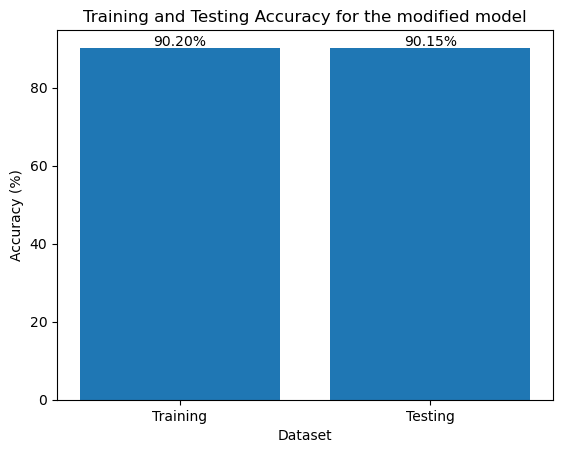

In [47]:
#Accuracy values for training and testing
train_acc, test_acc = 90.20, 90.15
datasets = ('Training', 'Testing')
accuracy_values = [train_acc, test_acc]

fig, ax = plt.subplots()
ax.bar(datasets, accuracy_values)

ax.set_title('Training and testing accuracy for the modified model')
ax.set_xlabel('Dataset')
ax.set_ylabel('Accuracy (%)')
for i, v in enumerate(accuracy_values):
    ax.text(i, v+0.5, f"{v:.2f}%", color='black', ha='center')
plt.show()

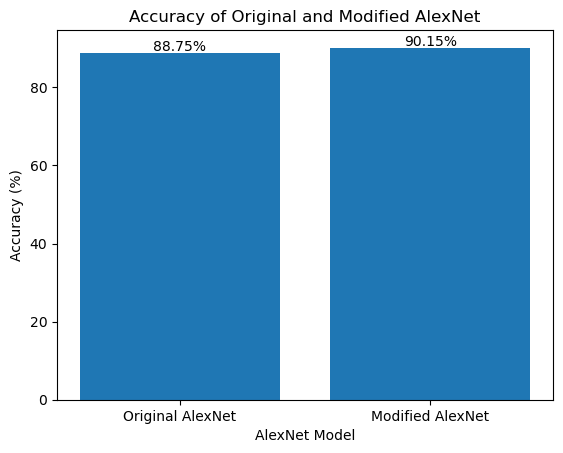

In [39]:
# Define the accuracy values for the original and modified AlexNet
org_model_acc, mod_model_acc = 88.75, 90.15

# Define the labels for the bars
models = ('Original AlexNet', 'Modified AlexNet')

# Define the accuracy values for the bars
accuracy_values = [org_model_acc, mod_model_acc]

# Create a bar chart
fig, ax = plt.subplots()
ax.bar(models, accuracy_values)

# Set the chart title and axis labels
ax.set_title('Accuracy of Original and Modified AlexNet')
ax.set_xlabel('AlexNet Model')
ax.set_ylabel('Accuracy (%)')

# Add percentage labels to the bars
for i, v in enumerate(accuracy_values):
    ax.text(i, v+0.5, f"{v:.2f}%", color='black', ha='center')

# Display the chart
plt.show()

**Part 4**

Import Packages

In [2]:
import numpy as np
import os
import cv2
import torchvision
from torchvision import transforms
import torchvision.datasets as datasets
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
# Define data transformations to be applied to the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
test_dataset = datasets.SVHN(root='./data', split='test', download=True, transform=transform)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

Number of training samples: 73257
Number of testing samples: 26032


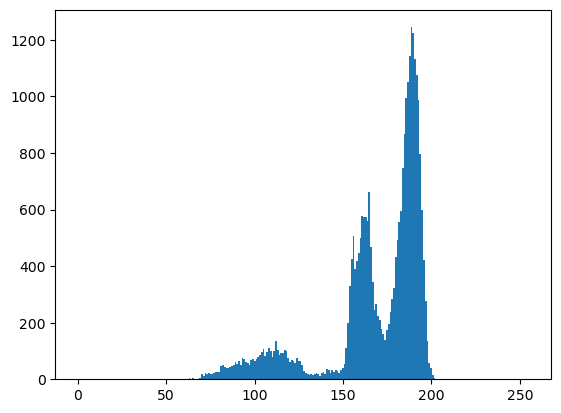

In [5]:
image_path = "/kaggle/input/svhn/test/1001.png"
img = Image.open(image_path)

# Convert the image to a numpy array
img_arr = np.array(img)

# Plot the histogram of the image
plt.hist(img_arr.ravel(), bins=256, range=(0, 255))
plt.show()

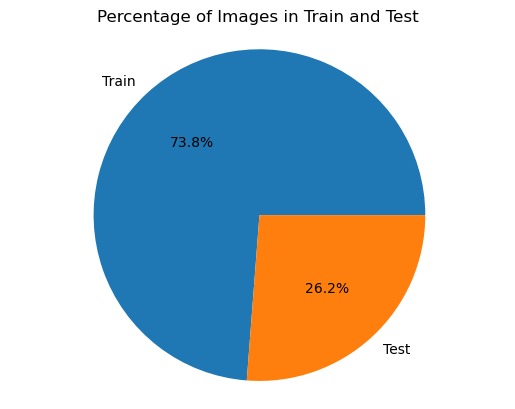

In [10]:
total_images_per_class = [len(train_dataset),len(test_dataset)]
plt.pie(total_images_per_class, labels=['Train','Test'], autopct='%1.1f%%')
plt.title("Percentage of Images in Train and Test")
plt.axis('equal')
plt.show()

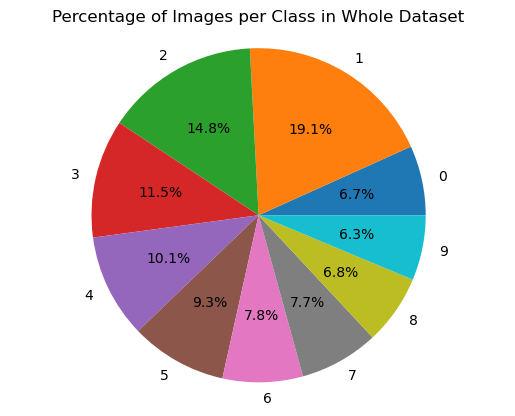

In [9]:
count_list = [0]*10
for i in train_dataset:
    if i[1] == 0:
        count_list[0] +=1
    elif i[1] == 1:
        count_list[1] += 1
    elif i[1] == 2:
        count_list[2] += 1
    elif i[1] == 3:
        count_list[3] += 1
    elif i[1] == 4:
        count_list[4] += 1
    elif i[1] == 5:
        count_list[5] += 1
    elif i[1] == 6:
        count_list[6] += 1
    elif i[1] == 7:
        count_list[7] += 1
    elif i[1] == 8:
        count_list[8] += 1
    elif i[1] == 9:
        count_list[9] += 1
for i in test_dataset:
    if i[1] == 0:
        count_list[0] +=1
    elif i[1] == 1:
        count_list[1] += 1
    elif i[1] == 2:
        count_list[2] += 1
    elif i[1] == 3:
        count_list[3] += 1
    elif i[1] == 4:
        count_list[4] += 1
    elif i[1] == 5:
        count_list[5] += 1
    elif i[1] == 6:
        count_list[6] += 1
    elif i[1] == 7:
        count_list[7] += 1
    elif i[1] == 8:
        count_list[8] += 1
    elif i[1] == 9:
        count_list[9] += 1
labels = ['0','1','2','3','4','5','6','7','8','9']
plt.pie(count_list, labels=labels, autopct='%1.1f%%')
plt.title("Percentage of Images per Class in Whole Dataset")
plt.axis('equal')
plt.show()

In [17]:
batch_size = 64

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
# Define the transforms for data augmentation
augmentation_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=(-90,90)),
    transforms.RandomPosterize(bits=2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the SVHN dataset for augmentation
aug_train_dataset = datasets.SVHN(root='./data', split='train', download=True, transform=augmentation_transforms)
aug_test_dataset = datasets.SVHN(root='./data', split='test', download=True, transform=augmentation_transforms)
num_train_samples = len(aug_train_dataset)
num_test_samples = len(aug_test_dataset)
input_shape = train_dataset[0][0].shape
num_classes = 10


print("Number of training samples:", num_train_samples)
print("Number of testing samples:", num_test_samples)
print("Input shape:", input_shape)
print("Number of classes:", num_classes)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
Number of training samples: 73257
Number of testing samples: 26032
Input shape: torch.Size([3, 32, 32])
Number of classes: 10


In [27]:
class ModifiedAlexNet(nn.Module):
    def __init__(self, num_classes=3):
        super(ModifiedAlexNet, self).__init__()

        # Define the convolutional layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Initialize the model
model = ModifiedAlexNet(num_classes=10).to(device)
aug_model = ModifiedAlexNet(num_classes=10).to(device)

In [35]:
#Creating data loader for with original and augmentated data
train_loader = torch.utils.data.DataLoader(torch.utils.data.ConcatDataset([train_dataset,aug_train_dataset]), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.ConcatDataset([test_dataset,aug_test_dataset]), batch_size=batch_size, shuffle=True)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(aug_model.parameters(), lr=0.01)

# Train using original and augmentated dataset
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    count = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = aug_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        count += 1
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('[%d, %5d] Accuracy: %.3f' %(epoch + 1, i + 1, correct / count))
    train_loss = correct / ((i + 1) * 64)

# Testing using original and augmentated dataset
correct = 0
total = 0
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = aug_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print('Test Accuracy: %.2f %%' % (test_acc * 100))


[1,  2290] Accuracy: 73.247
[2,  2290] Accuracy: 127.889
[3,  2290] Accuracy: 183.848
[4,  2290] Accuracy: 239.295
[5,  2290] Accuracy: 294.384
[6,  2290] Accuracy: 349.949
[7,  2290] Accuracy: 405.366
[8,  2290] Accuracy: 459.327
[9,  2290] Accuracy: 513.693
[10,  2290] Accuracy: 569.901
Test Accuracy: 87.16 %


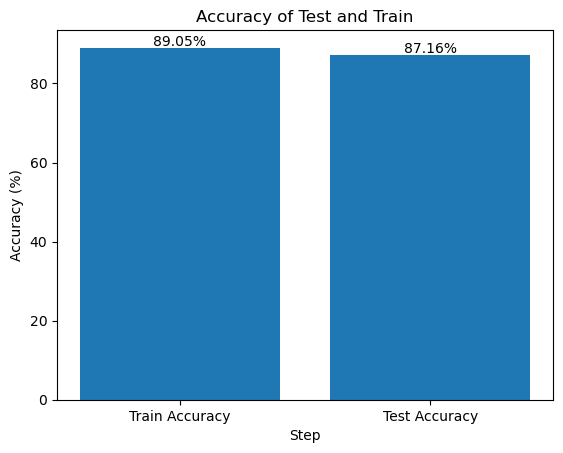

In [50]:
# Define the labels for the bars
models = ('Train Accuracy', 'Test Accuracy')

# Define the accuracy values for the bars
accuracy_values = [train_loss, test_acc*100]

# Create a bar chart
fig, ax = plt.subplots()
ax.bar(models, accuracy_values)

# Set the chart title and axis labels
ax.set_title('Accuracy of Test and Train')
ax.set_xlabel('Step')
ax.set_ylabel('Accuracy (%)')

# Add percentage labels to the bars
for i, v in enumerate(accuracy_values):
    ax.text(i, v+0.5, f"{v:.2f}%", color='black', ha='center')

# Display the chart
plt.show()